<a href="https://colab.research.google.com/github/spatank/CIS-522/blob/main/Homework/HW_11_SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 11 Homework


**Instructor:** Dinesh Jayaraman

**Content Creator:** Chuning Zhu

In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'spatank' #@param {type:"string"}
my_pod = 'sublime-newt' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


In [2]:
import time

# Section 1: Reading

For this week's homework assignment, you will read the [Rainbow DQN paper](https://arxiv.org/abs/1710.02298). Rainbow combines multiple extensions to the DQN algorithm. You will **read the first 3 pages** of the paper, which gives an overview of the DQN algorithm and its extensions. Choose one extension that interests you the most and write a short paragraph explaining what problem it addresses and how it works. Then, go through the corresponding ablation studies (page 6) and describe its ablation results. Feel free to dig further by reading the original paper that proposed the extension or finding online blogposts/articles. For your reference, here's a list of extensions covered in Rainbow:

- Double Q-learning
- Prioritized replay
- Dueling networks
- Multi-step learning
- Distributional RL
- Noisy Nets

In [3]:
#@markdown Which extension to DQN did you choose?
extension = "Double Q-learning" #@param ["Double Q-learning", "Prioritized replay", "Dueling networks", "Multi-step learning", "Distributional RL", "Noisy Nets"]
#@markdown What problem of DQN does it address? How does it work?
explanation = "When setting target Q values in DQN, we compute the maximum of the Q values that result from taking the next action in a given state. These target values are estimated using the same Q network as the one being actively trained. The max operator systematically overestimates the target values and biases them towards being higher than they actually are. DDQN solves this problem by maintaining a copy of the Q network. The first network is used to obtain the argument that has the maximum Q value, and the second network's output is indexed with this argument to get a target. This process replaces the max operator with the argmax and removes the oversampling bias." #@param {type:"string"}
#@markdown Describe its ablation results.
ablation = "Differences between DDQN and Rainbow are very minimal across the 57 Atari games. Performance worsens for almost as many games as it is improves without DDQN." #@param {type:"string"}
try:t1;
except NameError: t1 = time.time()

# Section 2: Coding

## Setup

In [6]:
# Install: 
# For grader: might need to run twice!
!apt install -q xvfb 
!apt-get update --fix-missing 
!pip install xvfbwrapper
!pip install -q pyvirtualdisplay

Reading package lists...
Building dependency tree...
Reading state information...
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
H

In [7]:
# Imports
import time
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

In [8]:
# Figure settings
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')

from IPython import display
from pyvirtualdisplay import Display

d = Display()
d.start();

## Implementing a simple DQN

In this section, you will code up a "vanilla" DQN without the bells and whistles to solve a simple task from OpenAI Gym. The goal is to get some hands-on experience with the Gym interface and writing a reinforcement learning training loop from scratch.

First, read through [Getting Started with Gym](https://gym.openai.com/docs/) to familiarize yourself with the OpenAI Gym library, and in particular its interface. Then, find the state dimension and the number of actions for the [MountainCar](https://gym.openai.com/envs/MountainCar-v0/) environment. Explain what the meaning of its states and actions.



In [9]:
env = gym.make('MountainCar-v0')
state_dim = 2
n_actions = 3
print(f'state_dim = {state_dim}, n_actions = {n_actions}')

state_dim = 2, n_actions = 3


In [10]:
#@markdown What is the state dimension?
state_dimension =  2#@param
#@markdown How many actions are there in this environment?
num_actions =  3#@param
#@markdown Explain what the states and actions correspond to in this environment.
meaning = "The state is a tuple comprised of position and velocity. The three available actions are acceleration to the left, acceleration to the right, or no acceleration." #@param {type:"string"}

try:t2;
except NameError: t2 = time.time()

The follow cell defines the QNetwork class. The Q network accepts a state vector as input and outputs the Q-values for all actions given the current state. Fill in missing parameters with your answers to the previous questions. 

In [11]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.state_dim = 2
        self.n_actions = 3
        self.hidden = 100

        self.layers = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden, bias = False),
            nn.Tanh(),
            nn.Linear(self.hidden, self.hidden, bias = False),
            nn.Tanh(),
            nn.Linear(self.hidden, self.n_actions, bias = False)
        )

    def forward(self, state):
        return self.layers(state)

Follow the instructions to complete epsilon-greedy policy and train_DQN function. Note that the raw reward of the environment is -1 for each timestep. To make learning easier, we define our own reward which considers the current position of the car. After obtaining the next state by executing an action, feed it to the provided reward_shaping function to get the shaped reward.

Recall that the loss of the Q network can be computed as $$\ell(\phi, s, a, r, s') = \left[Q_{\phi}(s, a) - \left(r + \gamma\max_{a'} Q_{\phi}(s', a')\right)\right]^2$$ and we update the Q network by performing a gradient-descent step $$\phi \leftarrow \phi - \alpha\nabla_{\phi}\ell(\phi, s, a, r, s')$$

In [12]:
def reward_shaping(next_state):
    # Reward is position + 0.5
    reward = next_state[0] + 0.5
    # If goal is reached, give additional reward
    if next_state[0] >= 0.5:
        reward += 1
    return reward

def epsilon_greedy(Q_values, epsilon):
    # Select an action using epsilon-greedy policy
    # Generate a random number between 0 and 1. If it is less than epsilon, then
    # sample a random action from the action space. Otherwise select the action
    # with the maximum Q-value.
    if random.random() < epsilon:
      action = env.action_space.sample()
    else:
      action = torch.argmax(Q_values).item()
    return action

def train_DQN(env, q_net, criterion, optimizer, scheduler, epsilon, discount, decay_rate, max_episodes):
    successes = []
    rewards = []
    losses = []
    ep_steps = 200
    for episode in range(max_episodes):
        ep_reward = 0
        ep_loss = 0
        state = env.reset()
        for s in range(ep_steps):

            # Step 1: forward state through q_net to get q values. 
            Q = q_net(torch.from_numpy(state).float())

            # Step 2: choose action using epsilon_greedy.
            action = epsilon_greedy(Q, epsilon)

            # Step 3: execute action in environment to get the next state.
            # Then use reward_shaping to get the shaped reward for training.
            # For logging purposes, do not change the provided variable names.
            next_state, _, done, _ = env.step(action)
            reward = reward_shaping(next_state)

            # Step 4: create Q_target from (s, a, r, s'). To do this, make a 
            # copy of the current Q values and only update the entry corresponding 
            # to the current action. Use Q.clone().detach() to make the copy.

            Q_copy = Q.clone().detach()
            Q_target = q_net(torch.from_numpy(next_state).float())
            Q_copy[action] = Q_target.max().item()
            Q_target = reward + discount * Q_copy
 
            # Step 5: compute loss using Q and Q_target and take one gradient 
            # step. Be sure to clear optimizer gradients before backpropagation.
            loss = criterion(Q, Q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Step 6: update state to next state.
            state = next_state

            # DO NOT MODIFY CODE BELOW
            ep_reward += reward
            ep_loss += loss.item()

            if done: 
                # Determine whether or not this is a success
                ep_success = float(next_state[0] >= 0.5)
                if ep_success:
                    # Decay the exploration parameter if we see success
                    epsilon = epsilon * decay_rate
                    # Step learning rate schduler
                    scheduler.step()
                
                # Print training info
                if (episode + 1) % 100 == 0:
                    print(f'Episode: {episode + 1}, reward: {ep_reward}, success: {ep_success}')

                # Logging
                successes.append(ep_success)
                rewards.append(ep_reward / ep_steps)
                losses.append(ep_loss / ep_steps)
                break
    
    return successes, rewards, losses     

Run the following cell to train your network.

In [13]:
# Set seeds for reproducibility
env.seed(1); torch.manual_seed(1);
env.reset()

# Hyperparameters. 
discount = 0.99         # environment discount factor
max_episodes = 1000     # number of episodes to train for
learning_rate = 0.001   # learning rate for optimizer
epsilon = 0.3           # episilon for greedy exploration
decay_rate = 0.95       # decay rate for epsilon

# Define network
q_net = QNetwork()
criterion = nn.MSELoss()
optimizer = optim.SGD(q_net.parameters(), learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, 0.9)

# Train network
successes, rewards, losses = train_DQN(env, q_net, criterion, optimizer, scheduler, epsilon, discount, decay_rate, max_episodes)

Episode: 100, reward: 15.948297694594558, success: 0.0
Episode: 200, reward: 18.005971233409102, success: 1.0
Episode: 300, reward: 18.61290905032117, success: 0.0
Episode: 400, reward: 21.07562874427171, success: 0.0
Episode: 500, reward: 24.23906352846532, success: 0.0
Episode: 600, reward: 22.0115393635149, success: 0.0
Episode: 700, reward: 19.68646374280289, success: 0.0
Episode: 800, reward: 23.74315859277644, success: 0.0
Episode: 900, reward: 24.798279389158076, success: 0.0
Episode: 1000, reward: 22.96829671906662, success: 0.0


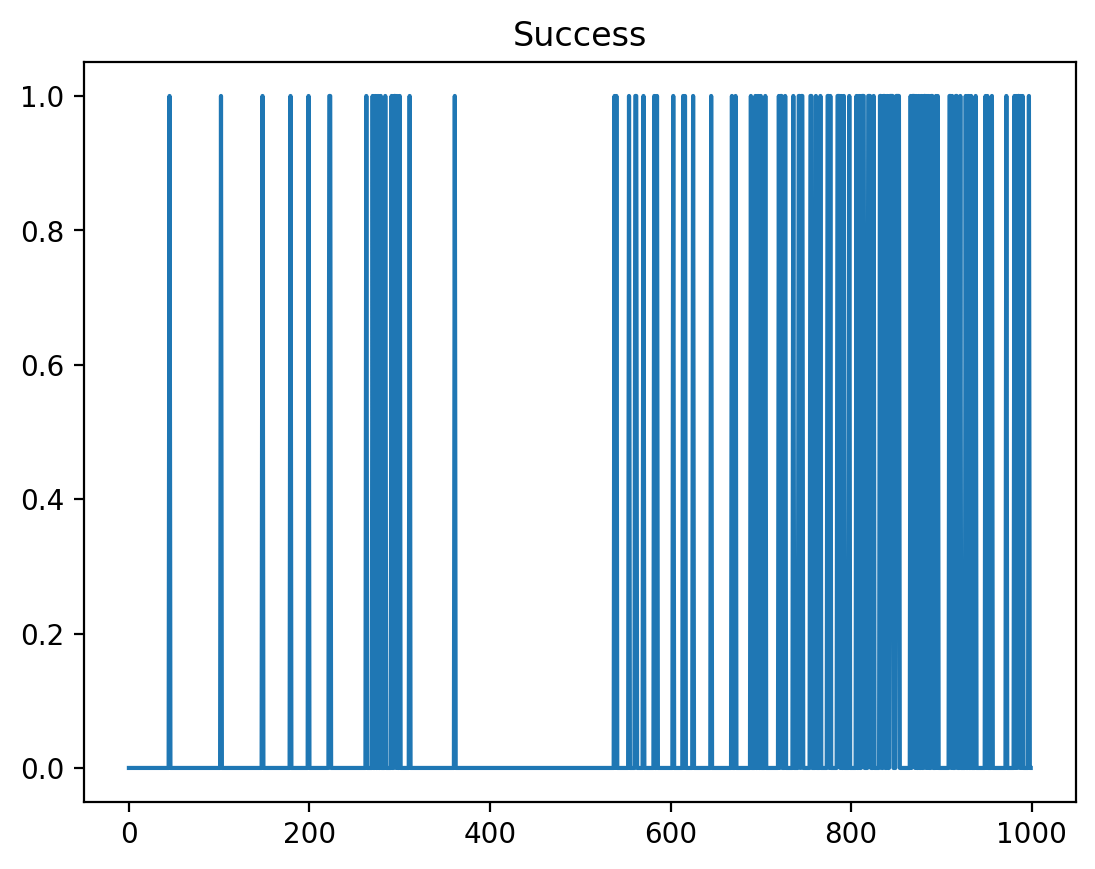

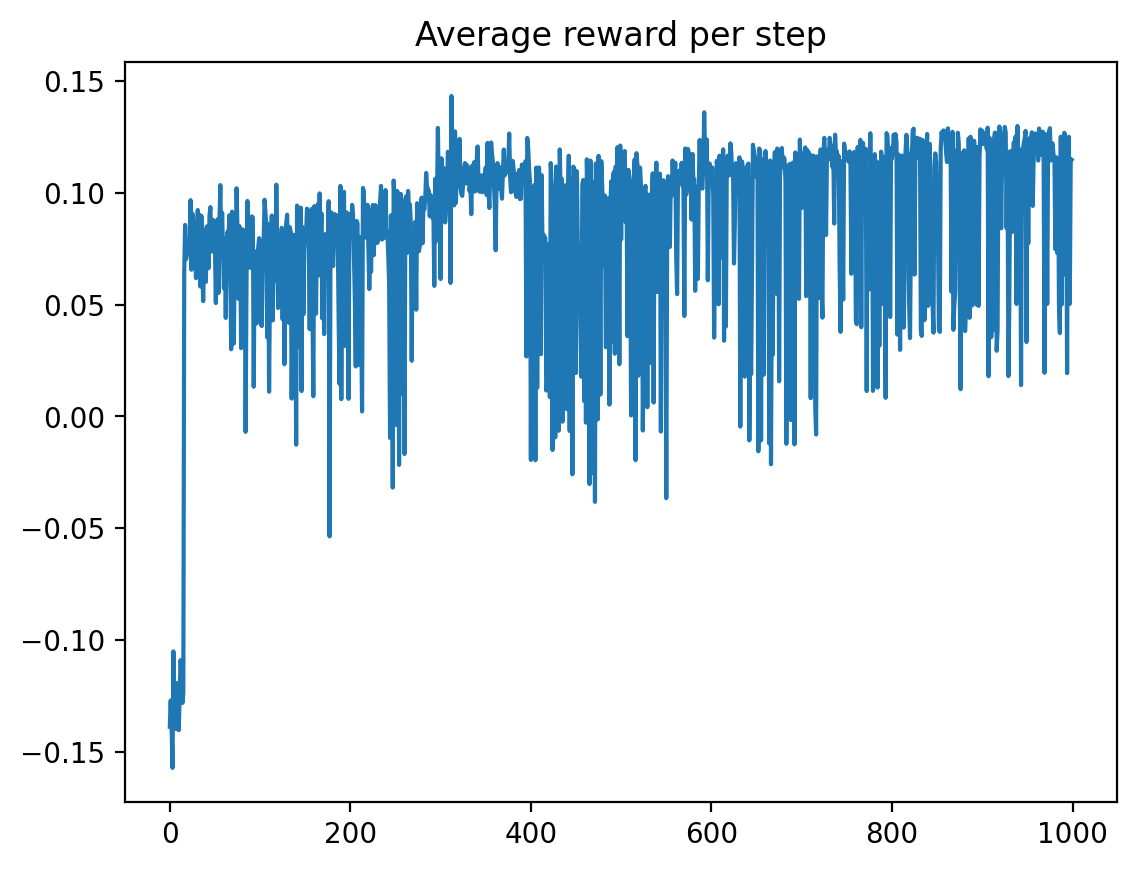

In [14]:
# @title Run cell to plot success and average true reward
plt.figure()
plt.plot(successes)
plt.title('Success')
plt.show()
plt.plot(rewards)
plt.title('Average reward per step')
plt.show()

In [15]:
# @title Run cell to visualize learned agent
def visualize(env, q_net, ep_steps):
    # Simulate agent in environment
    frames = []
    state = env.reset()
    for s in range(ep_steps):
        Q = q_net(torch.tensor(state, dtype=torch.float))
        action = epsilon_greedy(Q, epsilon)
        next_state, _, done, _ = env.step(action)

        display.clear_output(wait=True)
        frames.append(env.render('rgb_array'))
        state = next_state
        if done:
            break
    
    # Generate video
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animate = lambda i: patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=range(len(frames)), interval=50)
    plt.close() # avoid showing extra plots
    return anim
    
visualize(env, q_net, 200)

# Section 3: Ethics


## Part I: Societal Context of DRL: Perspective from Practitioners & Scholars
 
As the practical applications of Deep Reinforcement Learning continue to grow, practitioners and scholars are raising awareness of the potential societal and ethical risks and challenges that must be addressed.  To explore these issues, we will be reading excerpts from [The Societal Implications of Deep Reinforcement Learning](https://www.jair.org/index.php/jair/article/view/12360/26667) published in the *Journal of Artificial Intelligence Research*.
 
Read “Section 3: Challenges DRL Raises for Society, Ethics, and Governance,” which enumerates six specific areas of concern.  Select one of the concerns the authors identified and describe it below. Offer your analysis of why it is an important issue.
 

In [16]:
area_of_concern = "One area of concern that the authors outline is the potential mismatch between the reward function that designers may care about and the reward function that is holistically better for society-at-large. Most commercial entities are interested in maximizing profits. As such, the reward functions they employ seek to improve monetary outcomes such as clicks on advertisements, or on third-party sites. A recurring theme surrounding the discussion of ethics in this course so far has been how extreme content is easier to monetize. The unintended consequences of reward functions are not only hard to diagnose but companies also do not have any incentives to try." #@param {type:"string"}

try:t3;
except NameError: t3 = time.time()

Now, complete your reading of “Section 4: Avenues of Progress in DRL and their Implications,” “Section 5. Discussion” and “Section 6: Summary and Conclusion.”  Do the authors suggest any solutions to the concern you discussed above?  If so, describe their approach.  If not, do you have your own recommendation?


In [17]:
solution_to_concern = "While the authors do not directly suggest solutions to mitigate the issue of unintended reward function consequences, they discuss other ideas that may help address the problem. For instance, it is possible to construct reward functions that are multi-dimensional in nature. For instance, Facebook could seek some balance between clicks and user interests when making recommendations. This process could also be mandated by industry guidelines laid down by an independent watchdog." #@param {type:"string"}

try:t4;
except NameError: t4 = time.time()

## Part II: Stakeholder Perspective: A Proposed Multi-Factor Analysis for Governmental Use of Autonomous Systems
 
Next, consider the broader real-world uses of autonomous systems from the perspective of various users, spanning from corporate entities to government agencies.  Government agencies face particular ethical and legal challenges when confronted with the choice between adopting an artificial intelligence system or continuing to have humans making the decisions.
 
Read Part IV and the Conclusion of [“A Framework for Governmental Use of Machine Learning”](https://www.acus.gov/sites/default/files/documents/Coglianese%20ACUS%20Final%20Report%20w%20Cover%20Page.pdf), produced by Professor Cary Coglianese, University of Pennsylvania Law School, for the Administrative Conference of the United States (ACUS) in December 2020, which analyses the uses and implications of AI systems in the government and proposes a framework for public officials to use in deciding when to adopt AI tools. 
 
The report proposes a **multifactor analysis method** for government agencies to choose between AI and the status quo. Write a response addressing the following questions. 
- Considering your prior reading on the societal implications of DRL, is this multifactored method effective when agencies are faced with the choice of whether or not to adopt an autonomous system? 
- Are the prongs proposed in the report sufficient to address the issue you analyzed above? Why or why not? 
- Are these consistent with the proposals of the authors in “The Societal Implications of Deep Reinforcement Learning”? If not, which one do you think would better address the societal concerns arising from DRL? Would you propose a different approach?  
- In what ways do DRL systems introduce additional concerns than other autonomous systems?

In [20]:
part_2_response = "The authors present multiple considerations that determine whether an AI system should replace humans. The first of these is the Mathews calculus which seeks to identify the system that delivers more value in terms of accuracy and costs of implementation. The authors argue that AI has humans beat in most cases when it comes to this facet. The second consideration is a cost-benefit analysis where a more holistic view beyond mere accuracy is important. This has parallels to the discussion surrounding the unintended consequences of reward functions in RL. For instance, AI should not be used even if it is more accurate if it causes radicalization. Finally, the authors propose a multifactor evaluation; the pillars of which are goal clarity, data availability, and external validity. Goal clarity assesses how well a precise objective function can be written down for a problem. If an objective for optimization cannot be ascertained, then ML should not be used. This objective should also balance considerations of fairness. The latter two factors demand the availability of a sufficiently large data set to aid generalization, and an ability to re-train and re-evaluate as more data becomes available. In my view, the first factor is a catch-all in terms of the technical discussions we have had so far surrounding ML. For instance, designing a good objective function that suits the task at hand, and does not have unintended consequences is the gold standard for any ML problem. The authors of \u201CThe Societal Implications of Deep Reinforcement Learning\u201D also raise issues that can be tackled to some extent by dealing with the first factor proposed here. Additionally, they also raise the issue of continual learning leading to the exploration of unsafe regimes of operation, which in turn requires human oversight. The balancing act as far as RL is concerned seems to be the multifactor approach combined with oversight." #@param {type:"string"}

try:t5;
except NameError: t5 = time.time()

# Submission

Once you're done, click on 'Share' and add the link to the box below. If you did not use CoLab, you can also upload the file or notebook in the form below.

In [21]:
link = 'https://colab.research.google.com/drive/1-a6UEGLpbiCefHs0IfYt_uWvUYAAV5gI?usp=sharing' #@param {type:"string"}

In [22]:
import time
import numpy as np
import urllib.parse
from IPython.display import IFrame


#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**


def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: extension;
except NameError: extension = "Double Q-learning"
try: explanation;
except NameError: explanation = ""
try: ablation;
except NameError: ablation = ""
try: state_dimension;
except NameError: state_dimension = 0
try: num_actions;
except NameError: num_actions = 0
try: meaning;
except NameError: meaning = ""
try: area_of_concern;
except NameError: area_of_concern = ""
try: solution_to_concern;
except NameError: solution_to_concern = ""
try: part_2_response;
except NameError: part_2_response = ""
try: link;
except NameError: link = ""

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "extension": extension,
          "explanation": explanation,
          "ablation": ablation,
          "state_dimension": state_dimension,
          "num_actions": num_actions,
          "meaning": meaning,
          "area_of_concern": area_of_concern,
          "solution_to_concern": solution_to_concern,
          "part_2_response": part_2_response,
          "link": link}

src = "https://airtable.com/embed/shrb6cgGnu17S8MhJ?"


#now instead of the original source url, we do: src = prefill_form(src, fields)
display.display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))